In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load & Preprocess Dataset
# Define column names (since dataset lacks headers)
column_names = ["sentiment", "id", "date", "query", "user", "text"]

# Load dataset (update path if needed)
df = pd.read_csv(r"C:\Users\KIIT\Downloads\5training.1600000.processed.noemoticon (1).csv", encoding="ISO-8859-1", names=column_names)

# Keep only sentiment and text columns
df = df[["sentiment", "text"]]

# Convert sentiment labels (0 → Negative, 2 → Neutral, 4 → Positive)
df["sentiment"] = df["sentiment"].map({0: "negative", 2: "neutral", 4: "positive"})

# Check class distribution
print(df["sentiment"].value_counts())

sentiment
negative    800000
positive    800000
Name: count, dtype: int64


In [40]:
# Text Preprocessing

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.strip()  # Remove extra spaces
    return text

# Apply cleaning function
df["clean_text"] = df["text"].apply(clean_text)

#  Feature Extraction (TF-IDF)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

# Encode sentiment labels
y = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Ensure labels are correctly mapped
y_train = y_train.map({0: 0, 2: 1})
y_test = y_test.map({0: 0, 2: 1})

# Drop NaN values (caused by unmapped labels)
y_train = y_train.dropna().astype(int)
y_test = y_test.dropna().astype(int)

# Double-check unique values
print("Unique values in y_train:", y_train.unique())
print("Unique values in y_test:", y_test.unique())

Unique values in y_train: [1 0]
Unique values in y_test: [0 1]


In [5]:
print("Original unique values in y:", y.unique())
print("Value counts:\n", y.value_counts())

Original unique values in y: [0 2]
Value counts:
 sentiment
0    800000
2    800000
Name: count, dtype: int64


In [42]:
# Model Training & Evaluation

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\n📌 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    "solver": ["lbfgs", "liblinear"]  # Optimizers
}

# Grid Search
grid_lr = GridSearchCV(LogisticRegression(max_iter=500, random_state=42), param_grid_lr, cv=3, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Best parameters & model
print("Best Logistic Regression Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Evaluate
y_pred_best_lr = best_lr.predict(X_test)
print("Optimized Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best_lr))


📌 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

Best Logistic Regression Params: {'C': 1, 'solver': 'liblinear'}
Optimized Logistic Regression Accuracy: 0.790465625


In [43]:
#not included in the report
rf = RandomForestClassifier(
    n_estimators=50,  # Reduce number of trees
    max_depth=10,  # Limit tree depth
    min_samples_split=5,  # Prevent deep trees
    min_samples_leaf=2,  # Ensure minimum leaf nodes
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n📌 Optimized Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


📌 Optimized Random Forest Results:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70    159494
           1       0.69      0.79      0.74    160506

    accuracy                           0.72    320000
   macro avg       0.72      0.72      0.72    320000
weighted avg       0.72      0.72      0.72    320000



In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Convert labels: 4 → 1
y_train = y_train.replace(4, 1)
y_test = y_test.replace(4, 1)

# Define XGBoost model
xgb = XGBClassifier(
    n_estimators=100,   # Number of boosting rounds
    max_depth=6,        # Control tree depth
    learning_rate=0.1,  # Step size
    subsample=0.8,      # Prevent overfitting
    colsample_bytree=0.8,  # Use only part of features per tree
    n_jobs=-1,          # Use all CPU cores
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Print results
print("\n📌 XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))


📌 XGBoost Results:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71    159494
           1       0.70      0.79      0.74    160506

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Use SGD (Stochastic Gradient Descent) for faster training
svm = SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3, random_state=42)
svm.fit(X_train, y_train)

# Predictions
y_pred_svm = svm.predict(X_test)

# Accuracy
print("Fast SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

Fast SVM Accuracy: 0.7804625


In [46]:
# Convert predicted labels to numeric values (if still in text format)
label_mapping = {"negative": 0, "positive": 1}

# Logistic Regression
if isinstance(y_pred_lr[0], str):  
    y_pred_lr = [label_mapping[label] for label in y_pred_lr]

# SGD Classifier
if isinstance(y_pred_sgd[0], str):  
    y_pred_sgd = [label_mapping[label] for label in y_pred_sgd]

# XGBoost
if isinstance(y_pred_xgb[0], str):  
    y_pred_xgb = [label_mapping[label] for label in y_pred_xgb]

In [47]:
# Define label mapping
label_mapping = {"negative": 0, "positive": 1}

# Convert y_pred values to numeric labels if they are still in string format
def convert_predictions(y_pred):
    if isinstance(y_pred[0], str):  # Check if labels are still in text format
        return [label_mapping[label] for label in y_pred]  # Convert to numbers
    return y_pred

# Convert predictions
y_pred_lr = convert_predictions(y_pred_lr)
y_pred_sgd = convert_predictions(y_pred_sgd)
y_pred_xgb = convert_predictions(y_pred_xgb)

# Performance Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = {"Logistic Regression": y_pred_lr, "SGD Classifier": y_pred_sgd, "XGBoost": y_pred_xgb}

for model_name, y_pred in models.items():
    print(f"\n📌 {model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


📌 Logistic Regression Results:
Accuracy: 0.790340625
Confusion Matrix:
 [[123831  35663]
 [ 31428 129078]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000


📌 SGD Classifier Results:
Accuracy: 0.78048125
Confusion Matrix:
 [[121257  38237]
 [ 32009 128497]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.78    159494
           1       0.77      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000


📌 XGBoost Results:
Accuracy: 0.727575
Confusion Matrix:
 [[105801  53693]
 [ 33483 1270

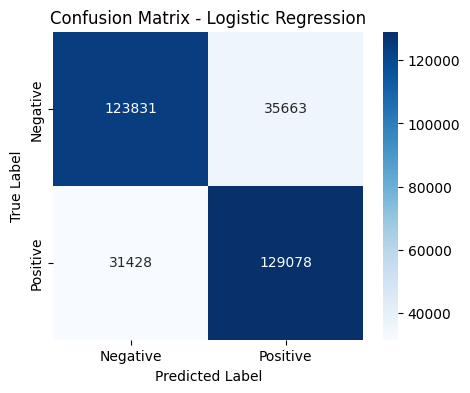

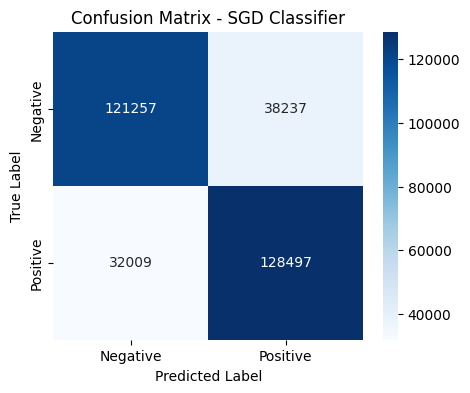

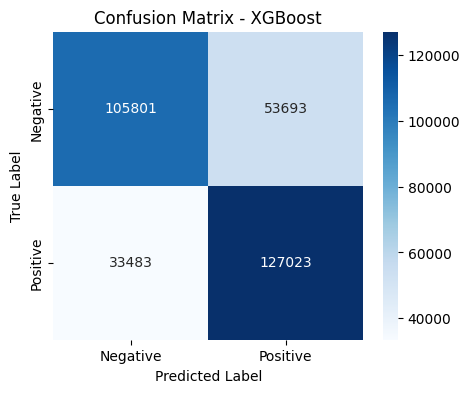

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_sgd, "SGD Classifier")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


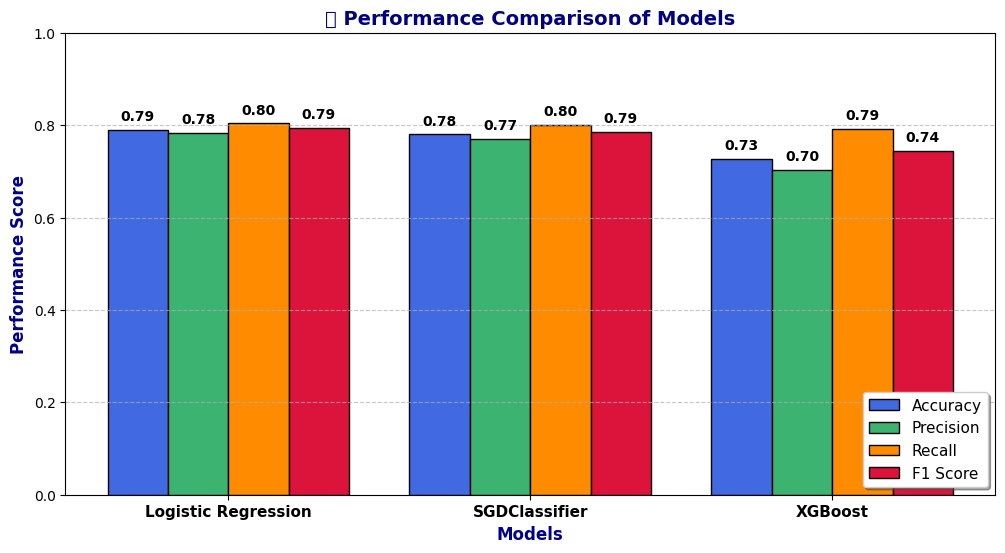

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute performance metrics
models = ["Logistic Regression", "SGDClassifier", "XGBoost"]
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_sgd),
    accuracy_score(y_test, y_pred_xgb)
]

precisions = [
    precision_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_sgd),
    precision_score(y_test, y_pred_xgb)
]

recalls = [
    recall_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_sgd),
    recall_score(y_test, y_pred_xgb)
]

f1_scores = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_sgd),
    f1_score(y_test, y_pred_xgb)
]

# Define bar width and positions
bar_width = 0.2
x = np.arange(len(models))

# Define colors
colors = ["royalblue", "mediumseagreen", "darkorange", "crimson"]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width*1.5, accuracies, width=bar_width, label="Accuracy", color=colors[0], edgecolor='black')
plt.bar(x - bar_width/2, precisions, width=bar_width, label="Precision", color=colors[1], edgecolor='black')
plt.bar(x + bar_width/2, recalls, width=bar_width, label="Recall", color=colors[2], edgecolor='black')
plt.bar(x + bar_width*1.5, f1_scores, width=bar_width, label="F1 Score", color=colors[3], edgecolor='black')

# Labels and formatting
plt.xlabel("Models", fontsize=12, fontweight="bold", color="darkblue")
plt.ylabel("Performance Score", fontsize=12, fontweight="bold", color="darkblue")
plt.title("📊 Performance Comparison of Models", fontsize=14, fontweight="bold", color="navy")
plt.xticks(x, models, fontsize=11, fontweight="bold", color="black")
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)

# Display values on top of bars
for i in range(len(models)):
    plt.text(x[i] - bar_width*1.5, accuracies[i] + 0.02, f"{accuracies[i]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(x[i] - bar_width/2, precisions[i] + 0.02, f"{precisions[i]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(x[i] + bar_width/2, recalls[i] + 0.02, f"{recalls[i]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(x[i] + bar_width*1.5, f1_scores[i] + 0.02, f"{f1_scores[i]:.2f}", ha='center', fontsize=10, fontweight='bold')

# Grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

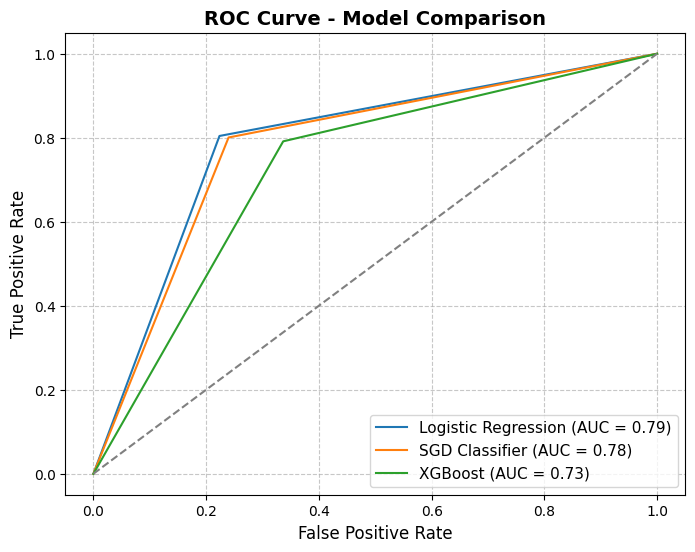

In [50]:
from sklearn.metrics import roc_curve, auc      #receiver operating characteristic
models = {"Logistic Regression": y_pred_lr, "SGD Classifier": y_pred_sgd, "XGBoost": y_pred_xgb}

plt.figure(figsize=(8,6))
for model, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random Guess Line
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Model Comparison", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()